In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import random

import shutup
shutup.please()

In [87]:
train = pd.read_csv(r"C:\Users\eryk\Desktop\Spaceship\train.csv")
test = pd.read_csv(r"C:\Users\eryk\Desktop\Spaceship\test.csv")

### Exploratory data analysis

In [88]:
train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Check data types

In [89]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Check for missing values

In [90]:
train.isna().sum()/train.shape[0]

PassengerId     0.000000
HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.000000
dtype: float64

<AxesSubplot:>

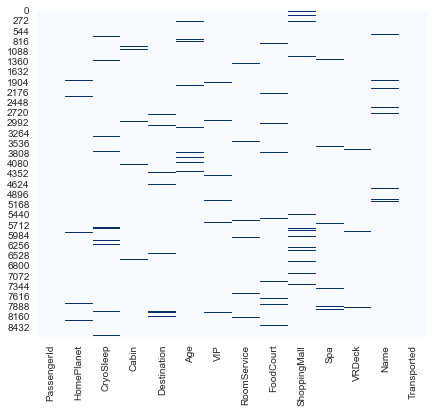

In [91]:
plt.subplots(figsize=(7,6))
sns.heatmap(train.isnull(), cbar=False, cmap='Blues')

<AxesSubplot:>

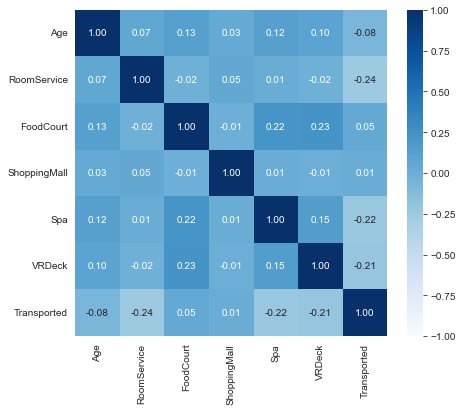

In [92]:
plt.subplots(figsize=(7,6))
sns.heatmap(train.corr(), cbar=True, cmap='Blues', annot=True, vmin=-1, vmax=1, fmt='.2f')

['Europa' 'Earth' 'Mars' nan]
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
[1 2 3 0]
[1 2 3 0]
[1 2 3]
[1 2 3]


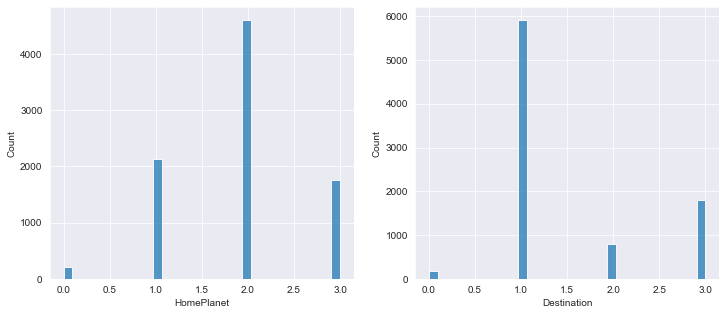

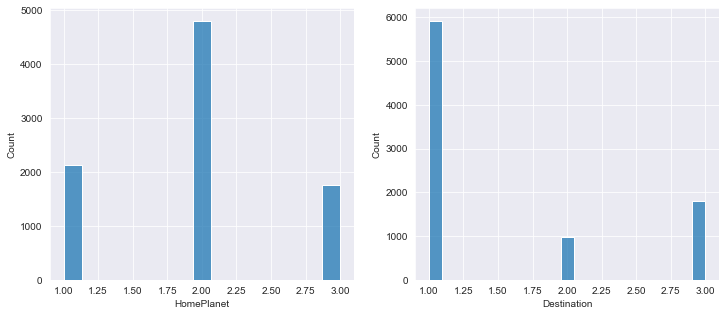

In [93]:
print(train['HomePlanet'].unique())
print(train['Destination'].unique())

train_temp = train.copy()
train_temp['HomePlanet'] = pd.factorize(train_temp['HomePlanet'])[0] + 1
train_temp['Destination'] = pd.factorize(train_temp['Destination'])[0] + 1

print(train_temp['HomePlanet'].unique())
print(train_temp['Destination'].unique())

fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(train_temp['HomePlanet'], ax=ax[0])
sns.histplot(train_temp['Destination'], ax=ax[1])
fig.show()

train_temp['HomePlanet'] = train_temp['HomePlanet'].replace(to_replace=0, value=random.randint(1,3))
train_temp['Destination'] = train_temp['Destination'].replace(to_replace=0, value=random.randint(1,3))
print(train_temp['HomePlanet'].unique())
print(train_temp['Destination'].unique())

fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(train_temp['HomePlanet'], ax=ax[0])
sns.histplot(train_temp['Destination'], ax=ax[1])
fig.show()

In [94]:
print("How many passengers entered on each planet?")
print(train_temp['HomePlanet'].value_counts())
print()
print("How many passengers were headed to where?")
print(train_temp['Destination'].value_counts())

How many passengers entered on each planet?
2    4803
1    2131
3    1759
Name: HomePlanet, dtype: int64

How many passengers were headed to where?
1    5915
3    1800
2     978
Name: Destination, dtype: int64


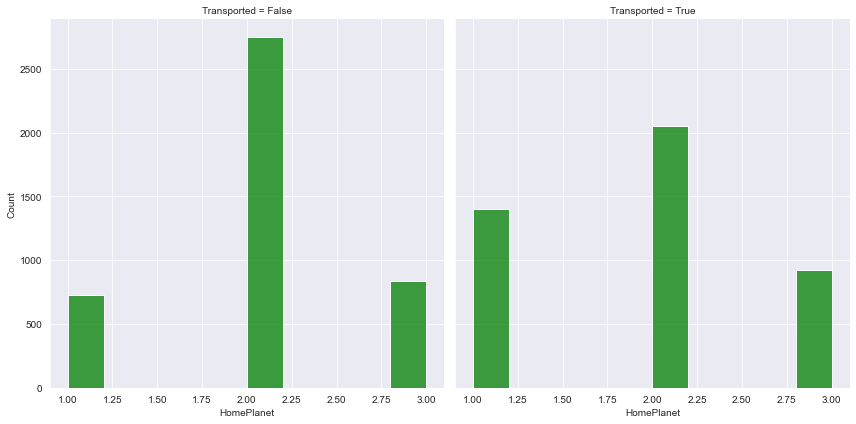

In [95]:
g = sns.FacetGrid(train_temp, col="Transported", size=6)
g.map_dataframe(sns.histplot, x="HomePlanet", bins=10, color='green')

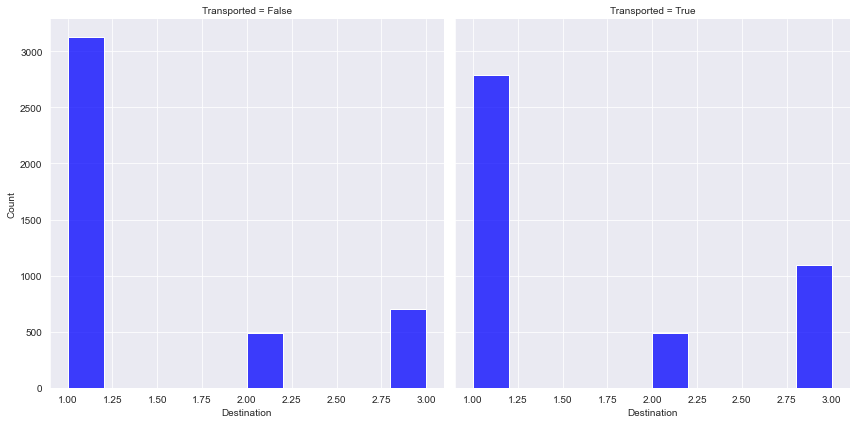

In [96]:
g = sns.FacetGrid(train_temp, col="Transported", size=6)
g.map_dataframe(sns.histplot, x="Destination", bins=10, color='blue')

In [97]:
X_train = train.drop("Transported", axis=1)
X_test = test.copy()
y_train = train["Transported"]

for df in [X_train, X_test]:
    df['HomePlanet'] = pd.factorize(df['HomePlanet'])[0] + 1
    df['Destination'] = pd.factorize(df['Destination'])[0] + 1
    df['HomePlanet'] = df['HomePlanet'].replace(to_replace=4, value=random.randint(1,3))
    df['Destination'] = df['Destination'].replace(to_replace=0, value=random.randint(1,3))

    scaler = StandardScaler()
    data=df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
    scaler.fit(data)
    df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = scaler.transform(data)
    df.fillna(method='backfill', inplace=True)

    df.loc[df['Age'] <= 22, 'Age'] = 0
    df.loc[(df['Age'] > 22) & (df['Age'] <= 33), 'Age'] = 1
    df.loc[df['Age'] > 33, 'Age'] = 2
    df['LastName'] = df['Name'].str.split(" ").str[1]

    df.drop('Name', axis=1, inplace=True)

    df['Family'] = df['LastName'].duplicated(keep=False)
    df.replace({False: 0, True: 1}, inplace=True)
    df.drop(['PassengerId', 'Cabin', 'LastName'], axis=1, inplace=True)

In [98]:
X_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Family
0,1,0,1,2.0,0,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,0
1,2,0,1,1.0,0,-0.173528,-0.278689,-0.245971,0.209267,-0.227692,1
2,1,0,1,2.0,1,-0.272527,1.934922,-0.287317,5.634034,-0.223327,1
3,1,0,1,1.0,0,-0.337025,0.511931,0.326250,2.655075,-0.097634,1
4,2,0,1,0.0,0,0.117466,-0.240833,-0.037590,0.223344,-0.264352,1


In [99]:
X_test.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Family
0,1,1,1,1.0,0,-0.361266,-0.287719,-0.316173,-0.271297,-0.249197,1
1,1,0,1,0.0,0,-0.361266,-0.281826,-0.316173,2.255891,-0.249197,0
2,2,1,2,1.0,0,-0.361266,-0.287719,-0.316173,-0.271297,-0.249197,0
3,2,0,1,2.0,0,-0.361266,4.067167,-0.316173,-0.109263,0.219987,0
4,1,0,1,0.0,0,-0.344790,-0.287719,0.816230,-0.271297,-0.249197,1


In [100]:
svm = SVC()
tree = DecisionTreeClassifier()
rf = RandomForestClassifier()
adaboost = AdaBoostClassifier()
xgb = XGBClassifier(verbosity=0)
xgbrf = XGBRFClassifier(verbosity=0)
mlp = MLPClassifier()
logit = LogisticRegression()

In [101]:
for model in [svm, tree, rf, adaboost, xgb, xgbrf, mlp, logit]:
    print("Accuracy for {0:23} = {1}".format(str(model).split("(")[0], np.round(cross_val_score(model, X_train, y_train, cv=5).mean(), 3)))

Accuracy for SVC                     = 0.784
Accuracy for DecisionTreeClassifier  = 0.742
Accuracy for RandomForestClassifier  = 0.787
Accuracy for AdaBoostClassifier      = 0.781
Accuracy for XGBClassifier           = 0.78
Accuracy for XGBRFClassifier         = 0.788
Accuracy for MLPClassifier           = 0.794
Accuracy for LogisticRegression      = 0.78


In [102]:
params = [
    {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']},
    {'C': [0.1, 1.0, 10.0], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': ['scale', 'auto']}
]

grid_svm = GridSearchCV(svm, params, cv=5)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.1, 1.0, 10.0], 'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'rbf', 'sigmoid']},
                         {'C': [0.1, 1.0, 10.0], 'degree': [2, 3, 4],
                          'gamma': ['scale', 'auto'], 'kernel': ['poly']}])

In [103]:
grid_svm.best_estimator_

SVC(C=10.0, gamma='auto')

In [104]:
grid_svm.best_score_

0.7884528163547824

In [105]:
params = [
    {'n_estimators': [50, 100, 200], 'max_features': ['sqrt', None]},
    {'n_estimators': [500, 1000], 'max_features': ['sqrt'], 'max_depth': [5, 10, None], 'min_samples_leaf': [1, 10, 20]}
]

grid_rf = GridSearchCV(rf, params, cv=5)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': ['sqrt', None],
                          'n_estimators': [50, 100, 200]},
                         {'max_depth': [5, 10, None], 'max_features': ['sqrt'],
                          'min_samples_leaf': [1, 10, 20],
                          'n_estimators': [500, 1000]}])

In [106]:
grid_rf.best_estimator_

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=500)

In [107]:
grid_rf.best_score_

0.7939750170560835

In [108]:
params = [
    {'learning_rate': [0.1, 0.01, 0.2], 'subsample': [0.6, 0.8, 0.9], 'colsample_bynode': [0.7, 0.8, 0.9], 'reg_lambda': [1e-06, 1e-05, 1e-04]}
]

grid_xgb = GridSearchCV(xgb, params, cv=5)
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [109]:
print(grid_xgb.best_estimator_)
print(grid_xgb.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.8, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1e-06,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=0)
0.7930550142238803


In [110]:
from sklearn.ensemble import VotingClassifier
clf = VotingClassifier(estimators=[('svm', svm), ('rf', rf), ('xgbrf', xgbrf)], voting='hard')
cv = cross_val_score(clf, X_train, y_train, cv=5)
cv, cv.mean()

(array([0.78550891, 0.77918344, 0.78608396, 0.80034522, 0.80494822]),
 0.7912139497919191)

In [111]:
clf = VotingClassifier(estimators=[('svm', SVC(C=10.0, gamma='auto')),
                                   ('rf', RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=1000)),
                                   ('xgb', XGBClassifier(learning_rate=0.01, colsample_bynode=0.8, reg_lambda=1e-06))],
                       voting='hard')
cv = cross_val_score(clf, X_train, y_train, cv=5)
cv, cv.mean()

(array([0.78378378, 0.77975848, 0.78953422, 0.8118527 , 0.80437284]),
 0.7938604054682697)

In [112]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [113]:
y_pred

array([ True, False,  True, ...,  True,  True,  True])

In [114]:
submission = pd.DataFrame({"PassengerId": test["PassengerId"], "Transported": y_pred})

In [115]:
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [116]:
submission.to_csv('submission.csv', index=False)